In [ ]:
%load_ext autoreload
%autoreload 2
import torch
torch.manual_seed(0) # Set seed before importing other modules
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import sys
import os
from models.unimodal import CentralUnimodalImage, CentralUnimodalAudio, UnimodalImage
import torch.nn as nn
import torch.optim as optim
from utils.get_data import get_dataloader_augmented
from training_structures.unimodal import train as unimodal_train, test as unimodal_test
from models.centralnet.centralnet import SimpleAV_CentralNet as CentralNet
from training_structures.centralnet_train import train_centralnet, test_centralnet
import matplotlib.pyplot as plt
from utils.visualisations import pca_plot_dataloaders, pca_plot_multiclass, show_images, show_images_augmentations, evaluate_results, plot_training_results_from_csv, plot_training_results_from_csvs
from torchvision import transforms, datasets
from torchmetrics.classification import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
from lightning.pytorch.strategies import DDPStrategy
import torch.multiprocessing
from models.dino import MultiModalDINOLightning, MultiModalDINO
from utils.get_data import get_dataloader_augmented, get_dataloader_dino
from training_structures.dino_train import pretrain_dino, train_downstream, train_knn_classifier 
from models.dino import MultiModalDINO, DownstreamClassifier, dino_loss
from utils.plots_trials import load_all_versions, plot_loss, process_metrics, create_plots_for_study, plot_study_results, save_versions_to_csv, create_enhanced_plots
import optuna
# torch.multiprocessing.set_start_method('spawn')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_path = os.getcwd()
model_files_path = os.path.join(current_path, 'model_saves', 'final_multimodal_dino_20250226_220312')
pca_plot_path = os.path.join(model_files_path, 'pca_plots')
plots_trials_path = os.path.join(model_files_path, 'plots_trials')
model_versions_path = os.path.join(model_files_path, 'versions')
final_model_path = os.path.join(model_files_path, 'multimodal_dino.ckpt')
best_model_path = os.path.join(model_files_path, 'epoch=23-step=13752.ckpt')
sys.path.append(current_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
module = MultiModalDINOLightning.load_from_checkpoint(best_model_path)
pretrained_dino : MultiModalDINO = module.model

In [65]:
traindata, validdata, testdata = get_dataloader_augmented(f'{current_path}/data/avmnist', type="burst_noise", batch_size=128, num_workers=0)
knn_model, knn_accuracy = train_knn_classifier(pretrained_dino, traindata, testdata, n_neighbors=5)

Extracting training features...
Extracting test features...
Training KNN classifier...
KNN Accuracy (k=5): 0.5910


In [66]:
classifier = train_downstream(
    pretrained_dino,
    traindata,
    validdata,
    testdata,
    num_epochs=10,
    device=device,
    save_path='model_saves/dino/downstream/downstream_model.pt',
    train_log_path='training_logs/dino/downstream/downstream_train_log.csv',
    test_log_path='test_logs/dino/downstream/downstream_test_log.csv'
)

Epoch 1/10: 100%|██████████| 430/430 [00:11<00:00, 37.27it/s, loss=0.967]


Epoch 1: Train Loss: 1.1820, Val Loss: 1.0322, Val Acc: 58.98%
Saved best model with validation accuracy: 58.98%


Epoch 2/10: 100%|██████████| 430/430 [00:11<00:00, 37.93it/s, loss=0.936]


Epoch 2: Train Loss: 1.0374, Val Loss: 1.0084, Val Acc: 59.62%
Saved best model with validation accuracy: 59.62%


Epoch 3/10: 100%|██████████| 430/430 [00:10<00:00, 40.40it/s, loss=0.951]


Epoch 3: Train Loss: 1.0153, Val Loss: 0.9928, Val Acc: 60.62%
Saved best model with validation accuracy: 60.62%


Epoch 4/10: 100%|██████████| 430/430 [00:11<00:00, 38.44it/s, loss=0.976]


Epoch 4: Train Loss: 1.0030, Val Loss: 0.9756, Val Acc: 61.22%
Saved best model with validation accuracy: 61.22%


Epoch 5/10: 100%|██████████| 430/430 [00:11<00:00, 37.52it/s, loss=1.05] 


Epoch 5: Train Loss: 0.9921, Val Loss: 0.9693, Val Acc: 61.52%
Saved best model with validation accuracy: 61.52%


Epoch 6/10: 100%|██████████| 430/430 [00:11<00:00, 37.98it/s, loss=0.907]


Epoch 6: Train Loss: 0.9851, Val Loss: 0.9672, Val Acc: 61.70%
Saved best model with validation accuracy: 61.70%


Epoch 7/10: 100%|██████████| 430/430 [00:11<00:00, 38.55it/s, loss=0.917]


Epoch 7: Train Loss: 0.9801, Val Loss: 0.9585, Val Acc: 62.18%
Saved best model with validation accuracy: 62.18%


Epoch 8/10: 100%|██████████| 430/430 [00:11<00:00, 37.83it/s, loss=0.875]


Epoch 8: Train Loss: 0.9753, Val Loss: 0.9547, Val Acc: 62.24%
Saved best model with validation accuracy: 62.24%


Epoch 9/10: 100%|██████████| 430/430 [00:10<00:00, 39.37it/s, loss=1.06] 


Epoch 9: Train Loss: 0.9706, Val Loss: 0.9552, Val Acc: 62.34%
Saved best model with validation accuracy: 62.34%


Epoch 10/10: 100%|██████████| 430/430 [00:10<00:00, 39.16it/s, loss=1.08] 


Epoch 10: Train Loss: 0.9696, Val Loss: 0.9537, Val Acc: 62.40%
Saved best model with validation accuracy: 62.40%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\training_structures\dino_train.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l


Test Accuracy: 62.08%


100%|██████████| 79/79 [00:01<00:00, 76.11it/s]


Selected digits for visualization: [9, 8]


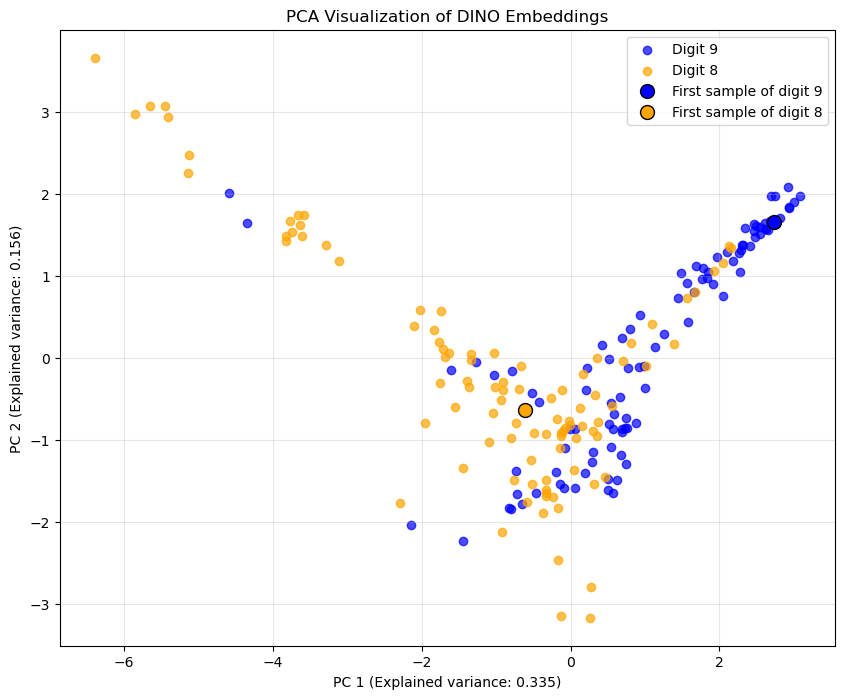

In [68]:
_ = pca_plot_dataloaders(pretrained_dino, testdata, selected_digits=[9, 8], dirpath=pca_plot_path)

100%|██████████| 79/79 [00:00<00:00, 80.78it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


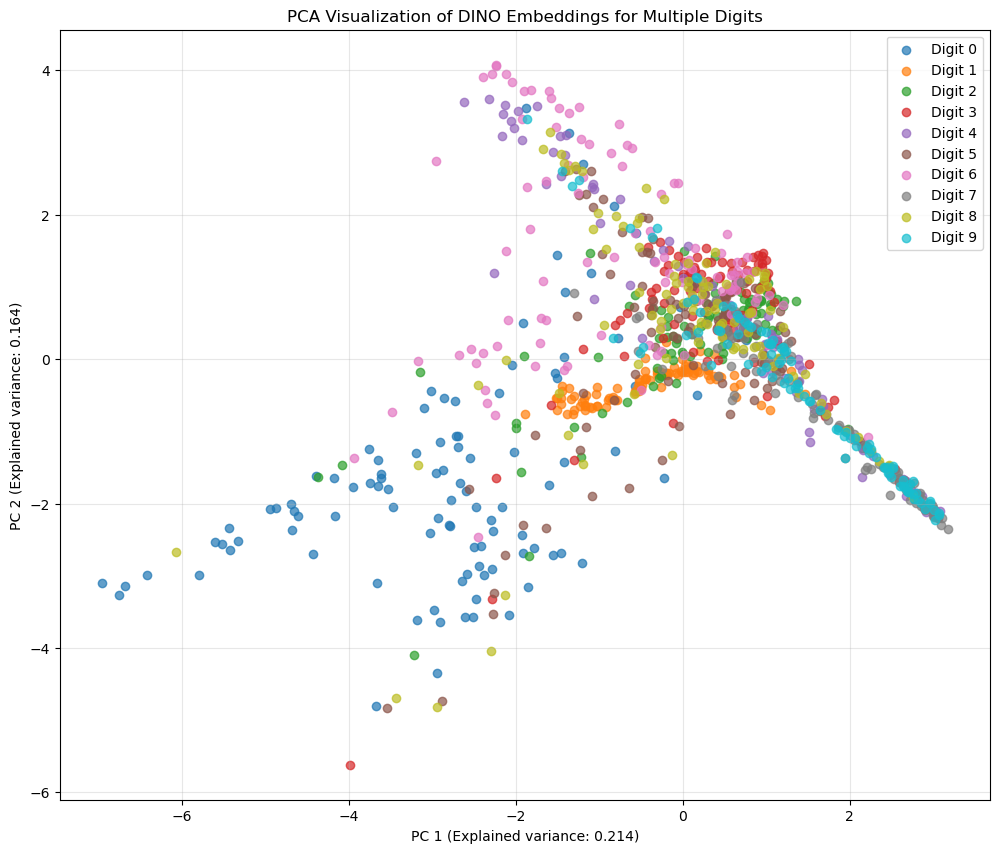

In [69]:
_ = pca_plot_multiclass(pretrained_dino, testdata, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dirpath=pca_plot_path)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000018686681DA0>
Traceback (most recent call last):
  File "c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Error creating Optuna plots: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
All plots created and saved to c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\model_saves\final_multimodal_dino_20250226_220312\plots_trials


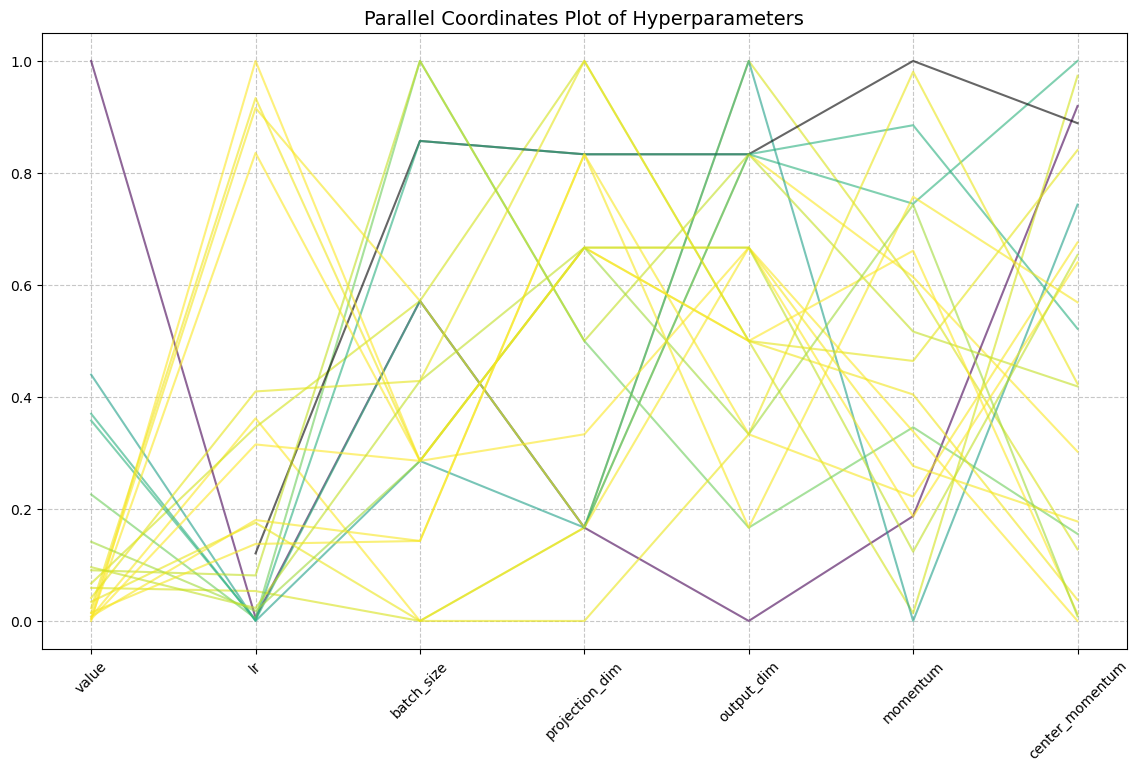

In [ ]:
# loaded_study = optuna.load_study(study_name="multimodal_dino", storage=f"sqlite:///{model_files_path}/studies.db")
# create_plots_for_study(loaded_study, versions_path=model_versions_path, plots_path=plots_trials_path)